In [33]:
import os
from datetime import datetime
import numpy as np
import glob

import PIL
import cartopy.img_transform as cit
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

In [2]:
SAT_IMAGERY_PATH = '/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs'

In [17]:
def get_directory_for_datetime(sat_imagery_path: str, dt: datetime) -> str:
    """
    Args:
        sat_imagery_path:
        dt: the datetime for the requested image.  Will return
            the directory which is within 5 minutes of the requested image.
    Returns:
        Directory string
        
    Raises:
        FileNotFoundError
    """
    hour_path = dt.strftime("%Y/%m/%d/%H")
    hour_path = os.path.join(SAT_IMAGERY_PATH, hour_path)
    
    # Get a list of subdirectories containing minutes
    _, minute_dirs, _ = next(os.walk(hour_path))
    minutes_with_images = np.array(minute_dirs, dtype=int)
    
    # Quantize dt.minute to 5-minute intervals
    minute_lower_bound = (dt.minute // 5) * 5
    minute_upper_bound = minute_lower_bound + 5
    
    # Find matching directory for the minutes
    selection_condition = (
        (minute_lower_bound <= minutes_with_images) & 
        (minutes_with_images < minute_upper_bound))
    idx = np.flatnonzero(selection_condition)
    
    # Sanity check
    if idx.size == 0:
        raise FileNotFoundError(2, 'No minute directory for datetime {} under "{}"'.format(dt, hour_path))
    elif idx.size > 1:
        raise RuntimeError(
            'Found > 1 directories with images for datetime {}.'
            '  Base dir = "{}".  Subdirs found = {}'
            .format(dt, hour_path, minute_dirs))
        
    selected_minute_dir = minutes_with_images[idx[0]]
    selected_minute_dir = '{:02d}'.format(selected_minute_dir)
    selected_minute_dir = os.path.join(hour_path, selected_minute_dir)
    
    return selected_minute_dir

dt = datetime(year=2017, month=7, day=1, hour=12, minute=0)
image_path = get_directory_for_datetime(SAT_IMAGERY_PATH, dt)
image_path

'/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs/2017/07/01/12/04'

In [129]:
def get_image_filename_for_datetime(
    sat_imagery_path: str, 
    dt: datetime,
    pattern: str = 'HRV*.jpg'
    ) -> str:
    
    image_path = get_directory_for_datetime(sat_imagery_path, dt)
    files = glob.glob(os.path.join(image_path, pattern))
    error_str = 'file matching "{}" in "{}" for datetime {}.'.format(pattern, image_path, dt)
    if len(files) == 0:
        raise FileNotFoundError(2, 'No ' + error_str)
    if len(files) > 1:
        raise RuntimeError('Found > 1 ' + error_str + '  Expected only one match.')
    image_filename = files[0]
    return image_filename

image_filename = get_image_filename_for_datetime(SAT_IMAGERY_PATH, dt)
image_filename

'/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs/2017/07/01/12/04/HRV_MSG2-SEVI-MSG15-0100-NA-20170701120417.jpg'

In [29]:
# Load image, re-project, crop



#CRS_GEOSTAT = pyproj.Proj("+proj=geos +lon_0=9.5 +h=35785831.0")
#CRS_TARGET = pyproj.Proj(
#    "+proj=tmerc +lat_0=0 +lon_0=9.5 +k_0=0.9996 +ellps=intl +units=m +no_defs")

In [130]:
image_filename = "/home/jack/data/EUMETSAT/testing/one-hour/format-4-jpeg/extracted/jpeg/HRV_MSG3-SEVI-MSG15-0100-NA-20190423080416.jpg"

In [131]:
image = PIL.Image.open(image_filename)

/home/jack/miniconda3/envs/sat_image_processing/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (124010496 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [133]:
def crop(img):
    img_middle = (img.shape[1] / 2) + 18
    hrv_image_width = 5568

    img_start_col = int(round(
        img_middle - (hrv_image_width / 2)
    ))

    img_end_col = int(round(
        img_middle + (hrv_image_width / 2)
    ))

    return img[:4176, img_start_col:img_end_col].copy()

image = crop(np.array(image))

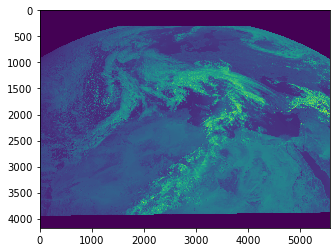

In [134]:
plt.imshow(image);

In [146]:
%%time
result_array, extent = cit.warp_array(
    np.array(image),
    source_proj=ccrs.Geostationary(
        central_longitude=9.5,
        globe=ccrs.Globe(
            semimajor_axis=6378169.0,
            semiminor_axis=6356583.8)
    ),
    target_proj=ccrs.TransverseMercator(),
    #target_res=(1000, 500)
)

CPU times: user 11min 36s, sys: 2.18 s, total: 11min 38s
Wall time: 6min


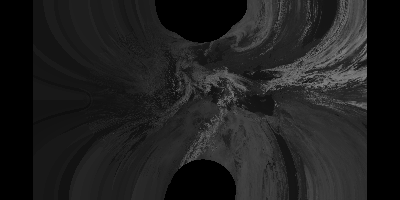

In [147]:
result = PIL.Image.fromarray(result_array)
result

In [173]:
import pyresample
from pyresample import geo_filter, geometry, load_area

seviri = geometry.AreaDefinition(
    area_id='seviri',
    description='SEVIRI RSS',
    proj_id='seviri',   
    projection={
         'proj': 'geos',
         'lon_0': 9.5,
         'a': 6378169.00,
         'b': 6356583.800000001,
         'h': 35785831.00,
         'units': 'm'},
    width=image.shape[1],
    height=image.shape[0],
    area_extent=(2799876.1893, 5571248.5489, -2768872.0236, 1394687.3892)
)

In [174]:
image.shape

(4176, 5568)

In [175]:
europe = geometry.AreaDefinition(
    area_id='areaD',
    description='Europe (3km, HRV, VTC)',
    proj_id='areaD',
    projection={
             #'a': '6378144.0',
             #'b': '6356759.0',
             'lat_0': '90.0',
             'lat_ts': '60.00',
             'lon_0': '0.00',
             'ellps': 'WGS84',
             'proj': 'stere'},
    width=image.shape[1], 
    height=image.shape[0],
    #area_extent=(2799876.1893, 5571248.5489, -2768872.0236, 1394687.3892))
    area_extent=[-3780000.0, -7644000.0, 3900000.0, -1500000.0])



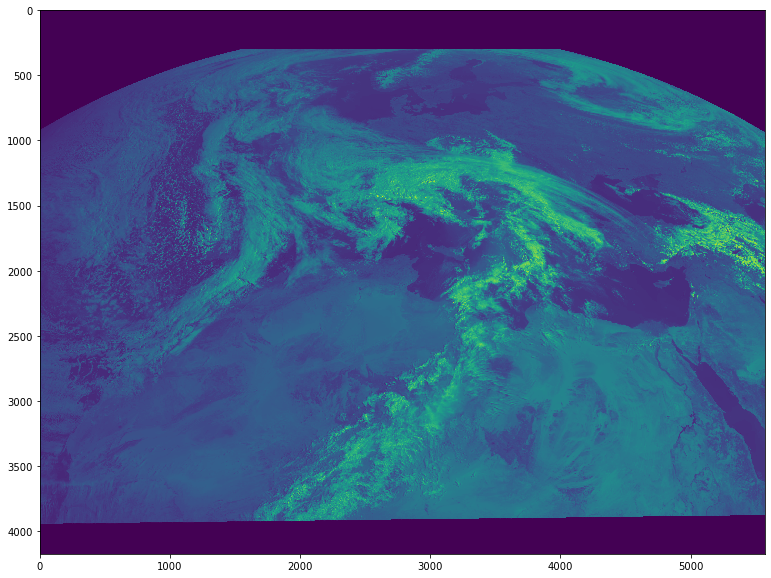

In [169]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image);

In [179]:
%%time
seviri_image = pyresample.image.ImageContainerQuick(np.array(image)[::-1, ::-1], seviri)
resampled = seviri_image.resample(europe)

CPU times: user 48.7 s, sys: 92.4 ms, total: 48.8 s
Wall time: 48.7 s


In [180]:
resampled.shape

(4176, 5568)

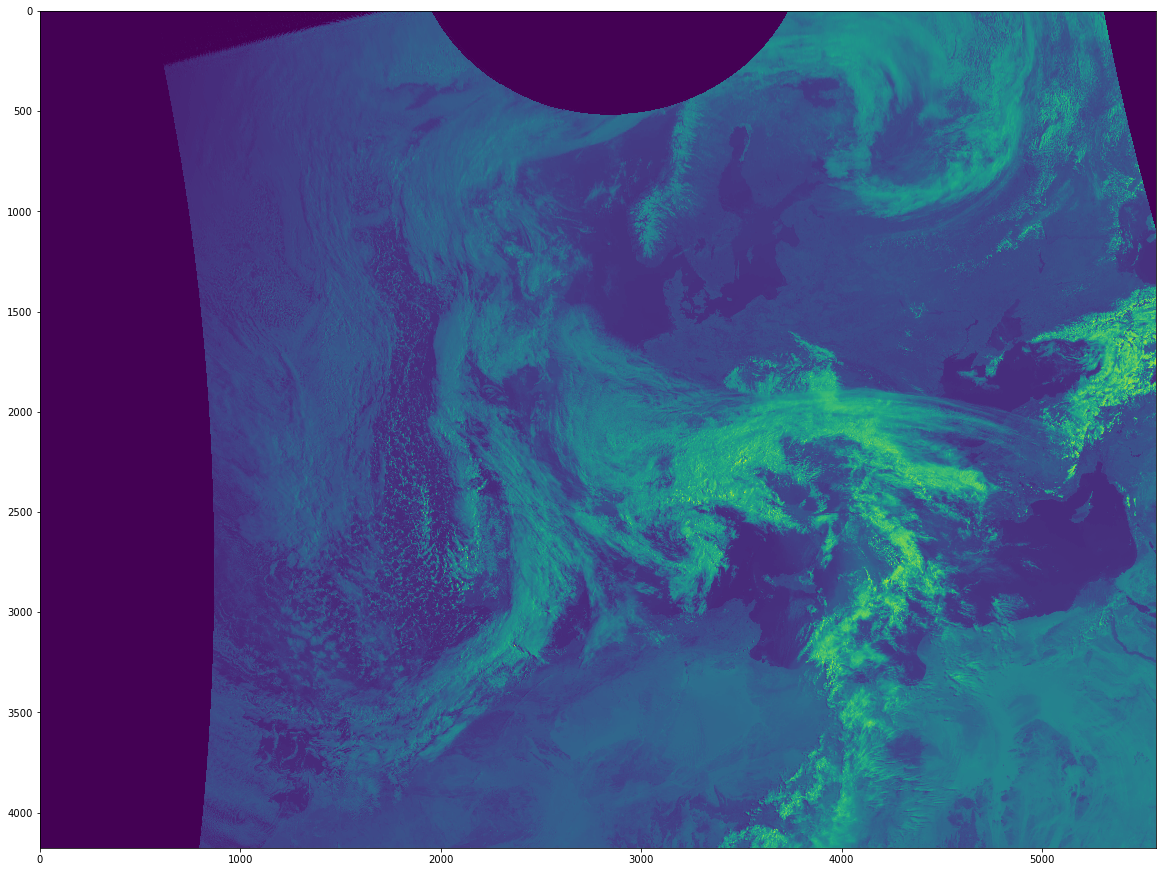

In [181]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(resampled.image_data);

## Failed attempt at using satpy

In [ ]:
import xarray as xr
import satpy

In [78]:
dataarray = xr.DataArray(image)
dataarray.attrs['name'] = 'seviri'
resampled = satpy.resample.resample(
    seviri,
    dataarray,
    europe
    )

Fill value incompatible with integer data using 255 instead.


AssertionError: Data dimensions do not match source area dimensions

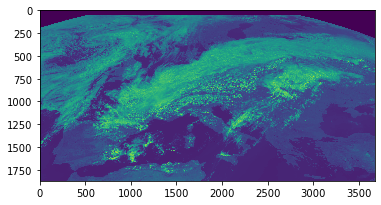

In [74]:
plt.imshow(resampled.values)